## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import warnings
import os
os.environ["TZ"] = "UTC"
warnings.filterwarnings("ignore")

USE_COLAB = False
if USE_COLAB == True:
    from google.colab import drive
    drive.mount('/content/drive')
    work_dir = '/content/drive/MyDrive/Colab Notebooks/sats4u/'
    secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'    
else:
    work_dir = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/sats4u/'
    secret_data_folder = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/crypto_project/crypto_data/'

os.chdir(work_dir)


In [2]:
! pip install -r requirements.txt

In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details, data_folder,verbose=False)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=False)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)

In [5]:
secrets_filename_test = secret_data_folder+'data_test.json'
crypto_test = lc.CryptoData(asset_details,data_folder,verbose = False)
crypto_test.load_binance_client(secrets_filename_test,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto_test.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto_test.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df_test = crypto_test.load_cryptos(tickers,save = False)  

In [6]:
crypto.binance_client.get_account()

{'makerCommission': 10,
 'takerCommission': 10,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': True,
 'canDeposit': True,
 'updateTime': 1651961431781,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BTC', 'free': '0.00224170', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNB', 'free': '0.00000664', 'locked': '0.00000000'},
  {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '107.65342381', 'locke

### Generate Candles and build features from technical analysis

In [7]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 5000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts(verbose=True)
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 5000 steps
Generated time-series
Normalized 'candles_norm' with shape : (5000, 9)
Feature data 'x_candles' with size : 4952
Feature data with time intervals 'x_time' with size : 4952


In [8]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220625_20_46"
initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [9]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

568

,Close,Pred Close
Date,,
2022-05-11 05:16:00,31626.88,31229.703886
2022-05-11 05:31:00,31498.30,31136.082853
2022-05-11 05:46:00,31438.77,31128.197633
2022-05-11 06:01:00,31439.68,31166.340626
2022-05-11 06:16:00,31325.11,31175.289647
...,...,...
2022-07-01 17:46:00,19487.94,19491.262394
2022-07-01 18:01:00,19481.51,19492.784448
2022-07-01 18:16:00,19488.49,19509.170256


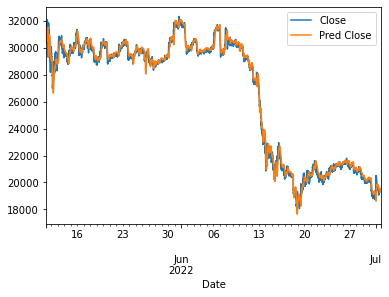

In [10]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period =  +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

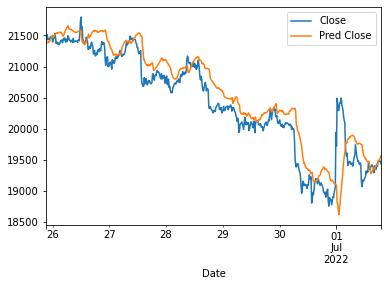

In [11]:
df_preds_true.iloc[-new_time_steps:].dropna().plot()


In [12]:
df_preds_true.dropna().iloc[-new_time_steps+300:]

,Close,Pred Close
Date,,
2022-06-29 00:01:00,20286.05,20583.851461
2022-06-29 00:16:00,20360.11,20568.774946
2022-06-29 00:31:00,20300.68,20518.455523
2022-06-29 00:46:00,20289.83,20511.748667
2022-06-29 01:01:00,20312.82,20506.426389
...,...,...
2022-07-01 17:46:00,19487.94,19491.262394
2022-07-01 18:01:00,19481.51,19492.784448
2022-07-01 18:16:00,19488.49,19509.170256


Initial time 2022-06-19 23:16:00
Final time 2022-07-01 18:46:00
Fee: 0.025
----------------------
Buy      1124 ( 643 ok 481 ko )
Avg PCT gain: 1.003029451571639
Avg PCT loss: 0.9972979286188343
Wins  PCT   0.5720640569395018
Avg PCT Gain.    1.003029451571639
No-op    0
Wallet   11418.23075000002
Drawback -785.8162499999978
Kelly Fraction    0.14657343059043043
Total earned 11418.23075000002


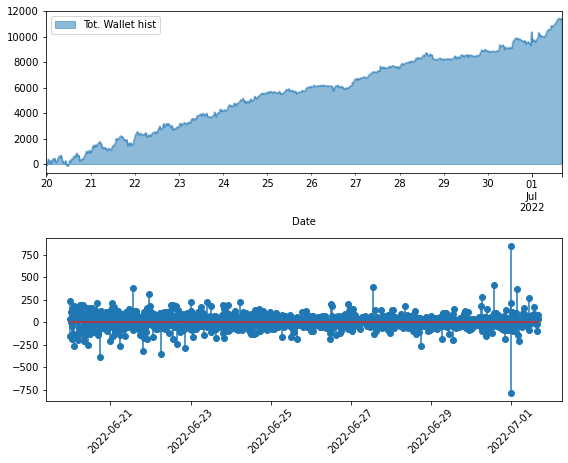

In [14]:
wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.iloc[-new_time_steps*2:].dropna(), step_back=+ 10,
                                                    long_short = "longshort", fee=0.025, cutoff_long = 10. ,cutoff_short = 10.0)
s2b.show_backtest_results(wallet,wallet_hist_df)


In [15]:
def tryexceptwait(func):
  def inner(*args,**kwargs):
        try:
          return func(*args, **kwargs)
        except:
          time.sleep(61)
          return func(*args,**kwargs)
  return inner

@tryexceptwait
def getminutedata(binance_client, ticker,interval, look_back):

    frame = pd.DataFrame(binance_client.get_historical_klines(ticker,interval, look_back + "min ago UTC"))

    frame = frame.iloc[:,:6]
    frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    frame = frame.set_index("Time")
    frame.index = pd.to_datetime(frame.index,unit = "ms")
    frame = frame.astype(float)
    return frame

In [21]:
investment = 1000.
conservative_kelly = kelly_frac*.5
portfolio = investment
open_position = False
avg_change = 0.004
fee = 0.025

ldata_df_new = crypto.load_cryptos(tickers, save=False)
elapsed_minutes = (pd.Timestamp(datetime.now()) -
                   ldata_df_new["Date"].iloc[-1]).seconds/crypto.dt
delta = ldata_df_new["Date"].iloc[-1]-ldata_df_new["Date"].iloc[-2]
time_condition = 1. < delta.seconds/crypto.dt - elapsed_minutes < + 1.
min_till_close = (delta.seconds/crypto.dt - elapsed_minutes)
print(f'Current Time: {pd.Timestamp(datetime.now())}')
print(f'Minutes till Next Close: {min_till_close}')
time.sleep(min_till_close*crypto.dt - 60)

while True:

  ldata_df_new = crypto.load_cryptos(tickers,save = False)
  can_btc = fb.Candles(ldata_df_new,"Bitcoin")
  can_btc.buildfeatures()
  ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = "15m",
                  lownorm = 0.2, upnorm= 0.8)

  ts_btc.candles2ts(verbose = False)
  ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
  ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
  initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
  loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
  loaded_model.sats2model()
  loaded_model.load_model(model_name)
  loaded_model.sats2pred(predict_on_test = False)
  loaded_model.load_scaler(model_name + '/scaler.sav')
  preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)
  new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
  df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
#  df_preds_true.dropna().iloc[-new_time_steps:].plot()
  df_preds_true_shifted = df_preds_true.copy()
  df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(10,delta)

  prev_true_close = df_preds_true_shifted.iloc[-2,0]
  prev_pred_close = df_preds_true_shifted.iloc[-2,1]
  pred_close = df_preds_true_shifted.iloc[-1,1]

  elapsed_minutes = (pd.Timestamp(datetime.now()) -
                    ldata_df_new["Date"].iloc[-1]).seconds/crypto.dt
  time_condition = 1. < delta.seconds/crypto.dt - elapsed_minutes < + 1.
  min_till_close = (delta.seconds/crypto.dt - elapsed_minutes)

  print(f'Current Time: {pd.Timestamp(datetime.now())}')
  print(f'Minutes till Next Close: {min_till_close}')

  if open_position == False :

    if prev_true_close*(1+fee/10.) < pred_close:

        #get price
        dff = getminutedata(crypto.binance_client, tickers[0],'1m','120')
        # Calculate how much to buy
        buy_quantity = round(portfolio*conservative_kelly / float(dff['Close'].iloc[-1]))
        buy_quantity = 0.001
        order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                    side='BUY',
                                                    type='MARKET',
                                                    quantity= buy_quantity)

        order_time = pd.Timestamp(datetime.now())
        est_close_time = df_preds_true.index[-1]+delta
        open_position = True
        buyprice = float(order['fills'][0]['price'])
        
        while open_position :

          dff = getminutedata(crypto.binance_client, tickers[0],'1m','2')
          current_price = dff["Close"].iloc[-1]
          current_time = pd.Timestamp(datetime.now())
          time_until_close = est_close_time - current_time

          print('-----------------------------------')
          print(f'order filled at {str(order_time)}')
          print(f'current Close is {dff.Close[-1]}')
          print(f'current Limit is {buyprice*(1+avg_change)} or close position in {str(time_until_close)}')
          print(f'current Stop is {buyprice*(1-avg_change)} or close position in {str(time_until_close)}')
          print(f'current Price is {current_price}')
          time.sleep(60)

          if 1 < (time_until_close.seconds/crypto.dt) < 1 :
            #or current_price > buyprice*(1+avg_change) or current_price < buyprice*(1-avg_change):

              order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                              side='SELL',
                                                              type='MARKET',
                                                              quantity= buy_quantity)
              print(f'Closed position at {order}')
              open_position = False
  else:
    time.sleep(61)                                                          



Current Time: 2022-07-01 20:44:03.598800
Minutes till Next Close: 1.9499999999999993
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-01 20:45:41.640180
Minutes till Next Close: -1424.6833333333334
-----------------------------------
order filled at 2022-07-01 20:45:42.634948
current Close is 19500.29
current Limit is 19578.301199999998 or close position in 0 days 00:30:16.753116
current Stop is 19422.2988 or close position in 0 days 00:30:16.753116
current Price is 19500.29


KeyboardInterrupt: 

In [28]:
order['fills'][0]['price']

'19500.30000000'

In [20]:
crypto_test.binance_client.get_account()


{'makerCommission': 0,
 'takerCommission': 0,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': False,
 'canDeposit': False,
 'updateTime': 1656707439512,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BNB',
   'free': '1000.00000000',
   'locked': '0.00000000'},
  {'asset': 'BTC', 'free': '1.00100000', 'locked': '0.00000000'},
  {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '100.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'},
  {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '9980.47960000', 'locked': '0.00000000'},
  {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}],
 'permissions': ['SPOT']}

In [ ]:
  delta = df_preds_true.index[1]-df_preds_true.index[0]
  df_preds_true_shifted = df_preds_true.copy()
  df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(ts_btc.step_back,delta)
  df_preds_true_shifted

In [ ]:
df_preds_true